In [1]:
from tqdm import tnrange, tqdm_notebook
from datetime import datetime, timedelta
import pandas
import numpy

# Import plot making tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=False)
import cufflinks as cf
cf.go_offline()

import plotly.io as pio

In [2]:
df = pandas.read_csv('results/5min_houses_pv_052014_052015_v0001.csv',
                     parse_dates=[0], index_col=[0])

# normalize pv data [0, 1]
df['pv_coef'] = df['pv_w/m2'] / 1000

# Varying PV sizes, what's the impact on self-production?

In [3]:
# PV coverage in the yearly netting case
pv_capacities = list(range(0, 70))
yearly_net_energy = [((df['pv_coef'] * j).sum() * 100 /
                      df['houses_kW'].sum()) 
                     for j in pv_capacities]

# PV coverage in the self-produced case without control
yearly_self_produced = []
tmp = df.copy()
for pv_capacity in tqdm_notebook(pv_capacities, desc='Progress'):
    tmp['pv_kW'] = tmp['pv_coef'] * pv_capacity
    tmp['self_kW'] =  tmp['pv_kW'] - tmp['houses_kW']
    tmp['self_kW'] = tmp.apply(lambda x: x['pv_kW'] if x['self_kW'] < 0 else x['houses_kW'], axis=1)
    yearly_self_produced.append(tmp['self_kW'].sum() * 100 / df['houses_kW'].sum())

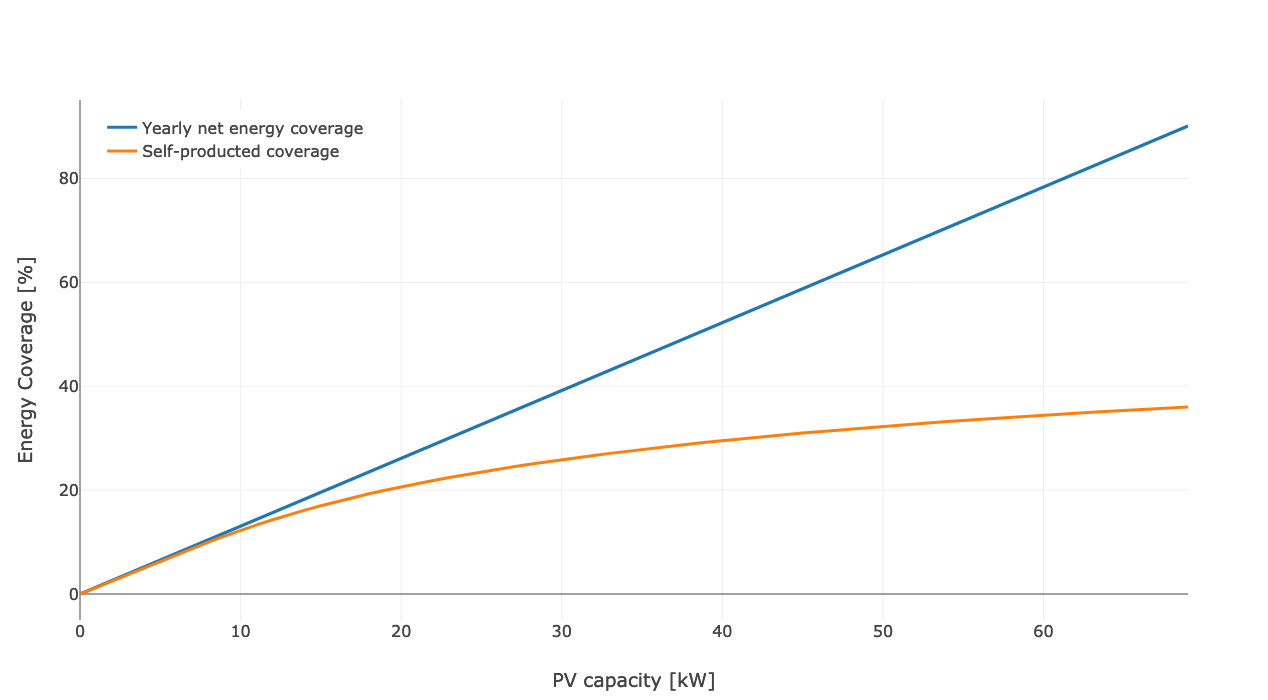

In [4]:
fig = {
    'data': [

        {'x': pv_capacities,
         'y': yearly_net_energy,
         'mode': 'lines',
         'line': {'width' : 3},
         'name': 'Yearly net energy coverage'},
        
        {'x': pv_capacities,
         'y': yearly_self_produced,
         'mode': 'lines',
         'line': {'width' : 3},
         'name': 'Self-producted coverage'},
    ]
,
    'layout': {
        'xaxis': {'title': 'PV capacity [kW]'},
        'yaxis': {'title': 'Energy Coverage [%]'},
        'showlegend': True,
        'legend': {'x': 0.02, 'y': .98},
        'font': {'size': 16},
        'width': 800,
        'height': 700,
    }
}
iplot(fig)

In [5]:
# Load low tech optimization
lowtech = pandas.read_pickle('results/lowtech_pv_sizes_battery=6kW2kW_nbhouse=all.obj')

In [6]:
# PV coverage in the self-produced case with low tech controller
pv_capacities = list(range(0, 70))
yearly_self_produced_lowtech = []
tmp = df.copy()
for pv_capacity in tqdm_notebook(pv_capacities, desc='Progress'):
    tmp['pv_kW'] = tmp['pv_coef'] * pv_capacity
    tmp['houses_batteries_kW'] = tmp['houses_kW'] + lowtech[pv_capacity]['battery_kW']
    tmp['self_kW'] =  tmp['pv_kW'] - tmp['houses_batteries_kW']
    tmp['self_kW'] = tmp.apply(lambda x: x['pv_kW'] if x['self_kW'] < 0 else x['houses_batteries_kW'], axis=1)
    yearly_self_produced_lowtech.append(tmp['self_kW'].sum() * 100 / tmp['houses_batteries_kW'].sum())

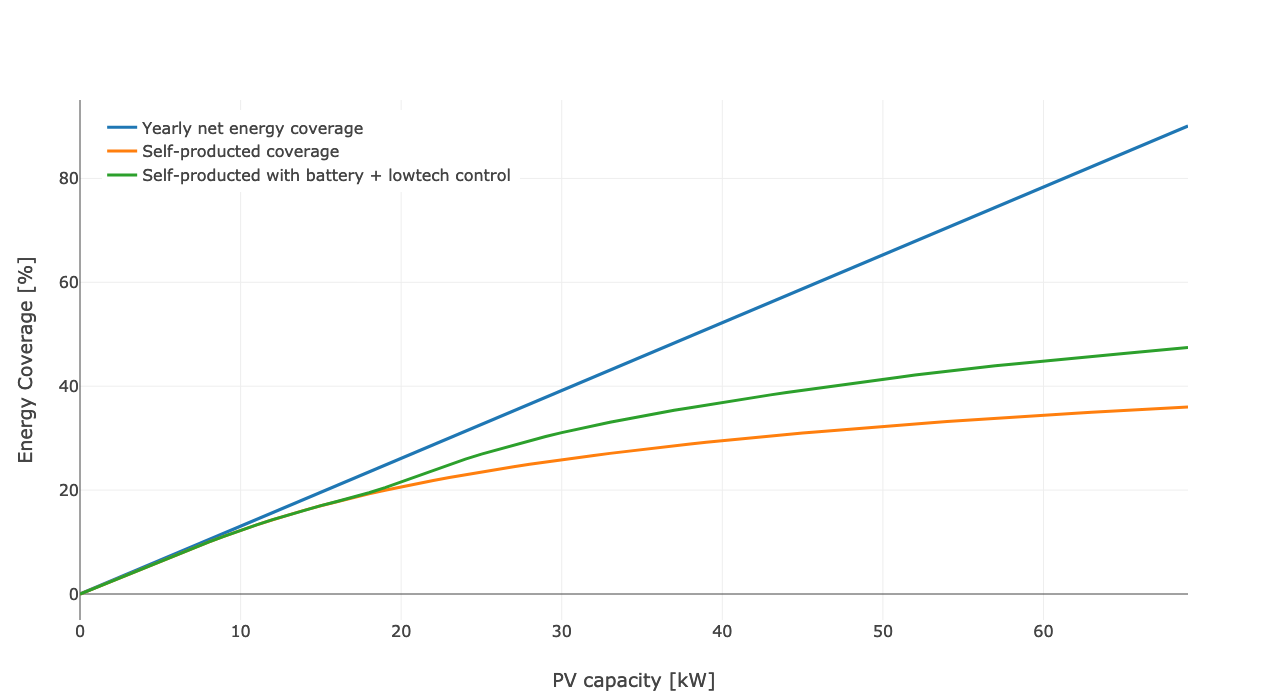

In [7]:
fig = {
    'data': [

        {'x': pv_capacities,
         'y': yearly_net_energy,
         'mode': 'lines',
         'line': {'width' : 3},
         'name': 'Yearly net energy coverage'},
        
        {'x': pv_capacities,
         'y': yearly_self_produced,
         'mode': 'lines',
         'line': {'width' : 3},
         'name': 'Self-producted coverage'},

        {'x': pv_capacities,
         'y': yearly_self_produced_lowtech,
         'mode': 'lines',
         'line': {'width' : 3},
         'name': 'Self-producted with battery + lowtech control'},
    ]
,
    'layout': {
        'xaxis': {'title': 'PV capacity [kW]'},
        'yaxis': {'title': 'Energy Coverage [%]'},
        'showlegend': True,
        'legend': {'x': 0.02, 'y': .98},
        'font': {'size': 16},
        'width': 800,
        'height': 700,
    }
}
iplot(fig)

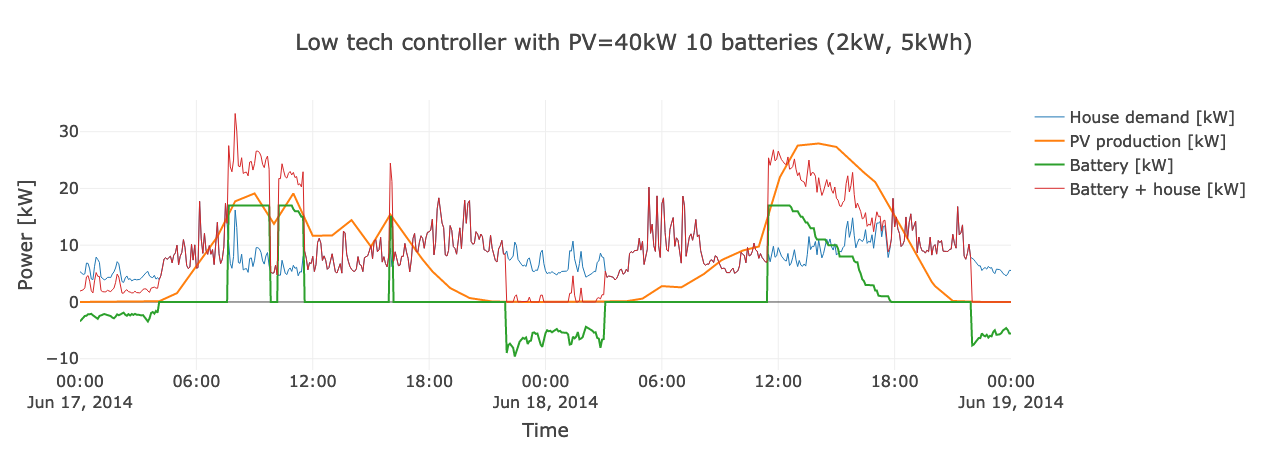

In [9]:
# tmp = df.copy()
# pv_capacity = 40
# tmp['pv_kW'] = tmp['pv_coef'] * pv_capacity
# start = '2014-06-17 00:00:00'
# end = '2014-06-19 00:00:00'

# fig = {
#     'data': [

#         {'x': tmp.loc[start:end, :].index,
#          'y': tmp.loc[start:end, 'houses_kW'],
#          'mode': 'lines',
#          'line': {'width' : 1},
#          'name': 'House demand [kW]'},
        
#         {'x': tmp.loc[start:end, :].index,
#          'y': tmp.loc[start:end, 'pv_kW'],
#          'mode': 'lines',
#          'line': {'width' : 2},
#          'name': 'PV production [kW]'},

#         {'x': lowtech[pv_capacity].loc[start:end, :].index,
#          'y': lowtech[pv_capacity].loc[start:end, 'battery_kW'],
#          'mode': 'lines',
#          'line': {'width' : 2},
#          'name': 'Battery [kW]'},
        
#         {'x': lowtech[pv_capacity].loc[start:end, :].index,
#          'y': (lowtech[pv_capacity].loc[start:end, 'battery_kW'] +
#                tmp.loc[start:end, 'houses_kW']),
#          'mode': 'lines',
#          'line': {'width' : 1},
#          'name': 'Battery + house [kW]'},
#     ]
# ,
#     'layout': {
#         'title': ('Low tech controller with PV=' + str(pv_capacity) + 'kW' +
#                   ' 10 batteries (2kW, 5kWh)'),
#         'xaxis': {'title': 'Time'},
#         'yaxis': {'title': 'Power [kW]'},
#         'showlegend': True,
# #         'legend': {'x': 0, 'y': 1.2},
#         'font': {'size': 16},
#         'height': 600,
#     }
# }
# iplot(fig)

In [8]:
# Load low tech optimization
predictive = pandas.read_pickle('results/glpk_pv_sizes_battery=6kW_nbhouse=all.obj')

In [9]:
# PV coverage in the self-produced case with low tech controller
pv_capacities = list(range(0, 70))
yearly_self_produced_predictive = []
tmp = df.copy()
for pv_capacity in tqdm_notebook(pv_capacities, desc='Progress'):
    tmp['pv_kW'] = tmp['pv_coef'] * pv_capacity
    tmp['houses_batteries_kW'] = (
        tmp['houses_kW'] +
        predictive[pv_capacity].loc[~predictive[pv_capacity].index.duplicated(keep='first'), 'battery_kW'])
    tmp['self_kW'] =  tmp['pv_kW'] - tmp['houses_batteries_kW']
    tmp['self_kW'] = tmp.apply(lambda x: x['pv_kW'] if x['self_kW'] < 0 else x['houses_batteries_kW'], axis=1)
    yearly_self_produced_predictive.append(tmp['self_kW'].sum() * 100 / tmp['houses_batteries_kW'].sum())

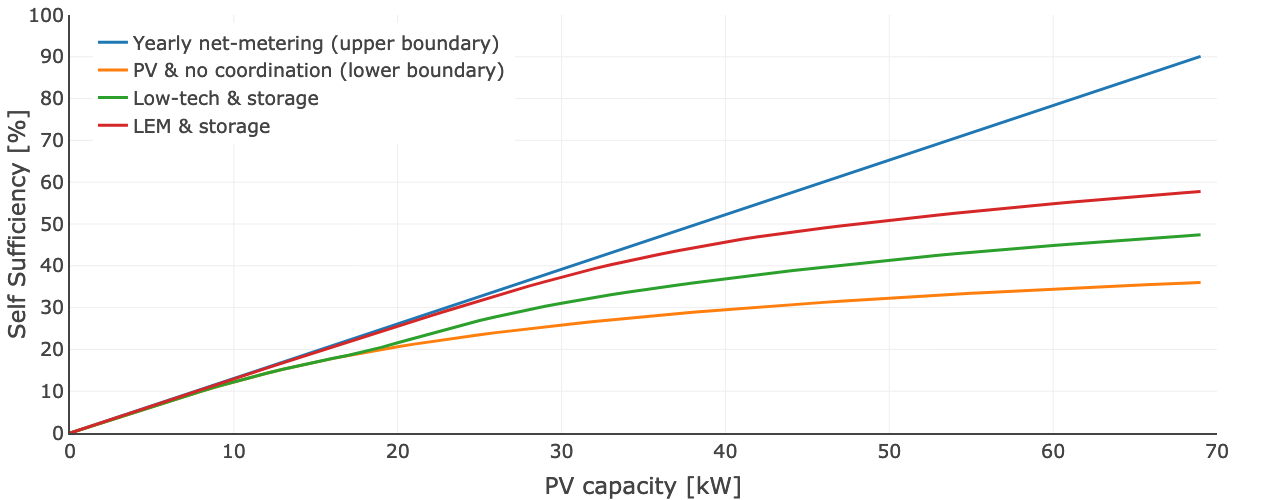

In [24]:
fig = {
    'data': [

        {'x': pv_capacities,
         'y': yearly_net_energy,
         'mode': 'lines',
         'line': {'width' : 3},
         'name': 'Yearly net-metering (upper boundary)'},
        
        {'x': pv_capacities,
         'y': yearly_self_produced,
         'mode': 'lines',
         'line': {'width' : 3},
         'name': 'PV & no coordination (lower boundary)'},

        {'x': pv_capacities,
         'y': yearly_self_produced_lowtech,
         'mode': 'lines',
         'line': {'width' : 3},
         'name': 'Low-tech & storage'},
        
        {'x': pv_capacities,
         'y': yearly_self_produced_predictive,
         'mode': 'lines',
         'line': {'width' : 3},
         'name': 'LEM & storage'},
    ]
,
    'layout': {
        'xaxis': {'title': 'PV capacity [kW]',
                 'linewidth': 2, 'showline': True,
                 'range':[0, 70]},
        'yaxis': {'title': 'Self Sufficiency [%]',
                 'linewidth': 2, 'dtick': 10,
                 'range':[0, 100]},
        'showlegend': True,
        'legend': {'x': 0.02, 'y': .98},
        'font': {'size': 19},
        'width': 800,
        'height': 500,
        'margin': {'l': 70, 't': 15, 'b': 67, 'r': 51},
    }
}
iplot(fig)

In [47]:
pio.write_json(fig, 'graphs/pvsizes.plotly')

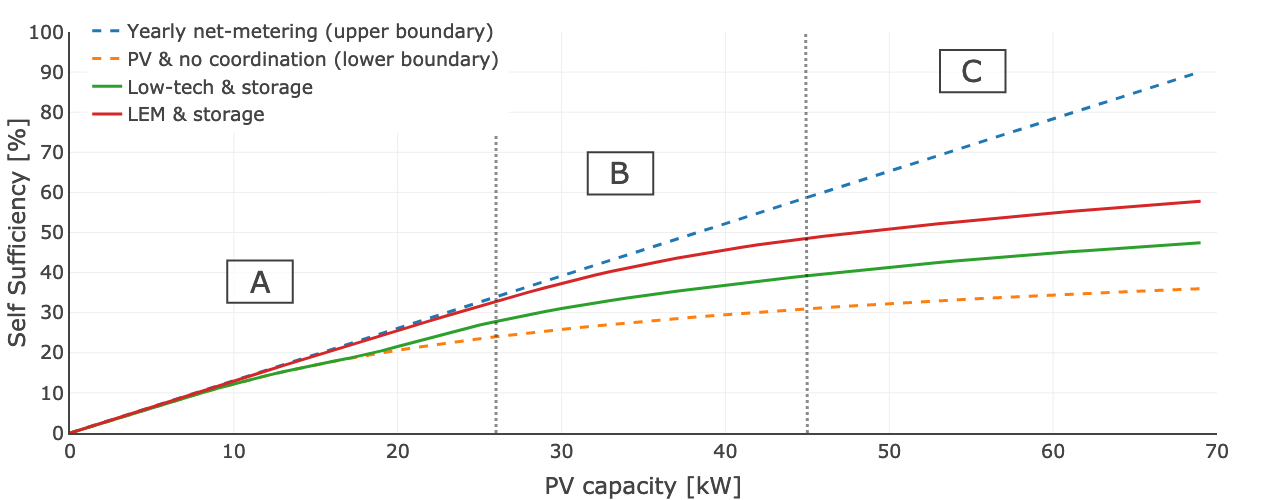

In [49]:
fig = {
  "data": [
    {
      "legendgroup": "nocontrol",
      "line": {
        "dash": "dash",
        "width": 3
      },
      "mode": "lines",
      "name": "Yearly net-metering (upper boundary)",
      "type": "scatter",
      "x": pv_capacities,
      "y": yearly_net_energy
    },
    {
      "legendgroup": "nocontrol",
      "line": {
        "dash": "dash",
        "width": 3
      },
      "mode": "lines",
      "name": "PV &amp; no coordination (lower boundary)",
      "type": "scatter",
      "x": pv_capacities,
      "y": yearly_self_produced
    },
    {
      "legendgroup": "control",
      "line": {
        "width": 3
      },
      "mode": "lines",
      "name": "Low-tech & storage",
      "type": "scatter",
      "x": pv_capacities,
      "y": yearly_self_produced_lowtech
    },
    {
      "legendgroup": "control",
      "line": {
        "width": 3
      },
      "mode": "lines",
      "name": "LEM & storage",
      "type": "scatter",
      "x": pv_capacities,
      "y": yearly_self_produced_predictive
    }
  ],
  "layout": {
    "font": {
      "size": 19
    },
    "height": 500,
    "legend": {
      "orientation": "v",
      "x": 0.015,
      "y": 1.05,
      "tracegroupgap": 0,
      "xanchor": "left",
      "bgcolor": "rgb(255, 255, 255)"
    },
    "margin": {
      "b": 67,
      "l": 70,
      "r": 51,
      "t": 15
    },
    "showlegend": True,
    "width": 800,
    "xaxis": {
      "linewidth": 2,
      "range": [
        0,
        70
      ],
      "showline": True,
      "title": {
        "text": "PV capacity [kW]"
      },
      "type": "linear",
      "autorange": False
    },
    "yaxis": {
      "dtick": 10,
      "linewidth": 2,
      "range": [
        0,
        100
      ],
      "title": {
        "text": "Self Sufficiency [%]"
      },
      "type": "linear",
      "autorange": False
    },
    "shapes": [
      {
        "line": {
          "color": "rgb(0, 0, 0)",
          "width": 3,
          "dash": "dot"
        },
        "fillcolor": "#7f7f7f",
        "opacity": 0.45,
        "x0": 26,
        "x1": 26,
        "y0": 0,
        "y1": 97.96918767507003,
        "type": "line"
      },
      {
        "line": {
          "color": "rgb(0, 0, 0)",
          "dash": "dot",
          "width": 3
        },
        "fillcolor": "#7f7f7f",
        "opacity": 0.45,
        "x0": 45,
        "x1": 44.896907216494846,
        "y0": 0,
        "y1": 101.6358543417367,
        "type": "line"
      },
      {
        "line": {
          "color": "rgb(0, 0, 0)"
        },
        "fillcolor": "rgb(255, 255, 255)",
        "opacity": 0.75,
        "x0": 9.6,
        "x1": 13.6,
        "y0": 32.5,
        "y1": 43
      },
      {
        "line": {
          "color": "rgb(0, 0, 0)"
        },
        "fillcolor": "rgb(255, 255, 255)",
        "opacity": 0.75,
        "x0": 31.6,
        "x1": 35.6,
        "y0": 59.5,
        "y1": 70
      },
      {
        "line": {
          "color": "rgb(0, 0, 0)"
        },
        "fillcolor": "rgb(255, 255, 255)",
        "opacity": 0.75,
        "x0": 53.1,
        "x1": 57.1,
        "y0": 85,
        "y1": 95.5
      }
    ],
    "annotations": [
      {
        "text": "A",
        "ax": -136,
        "ay": 0,
        "x": 11.6,
        "y": 38,
        "showarrow": False,
        "font": {
          "size": 30
        }
      },
      {
        "text": "B",
        "showarrow": False,
        "font": {
          "size": 30
        },
        "x": 33.55670103092784,
        "y": 65.1
      },
      {
        "text": "C",
        "showarrow": False,
        "font": {
          "size": 30
        },
        "x": 55,
        "y": 90.5
      }
    ]
  },
  "frames": []
}
iplot(fig)

In [50]:
pio.write_image(fig, "graphs/pvsizes.pdf")

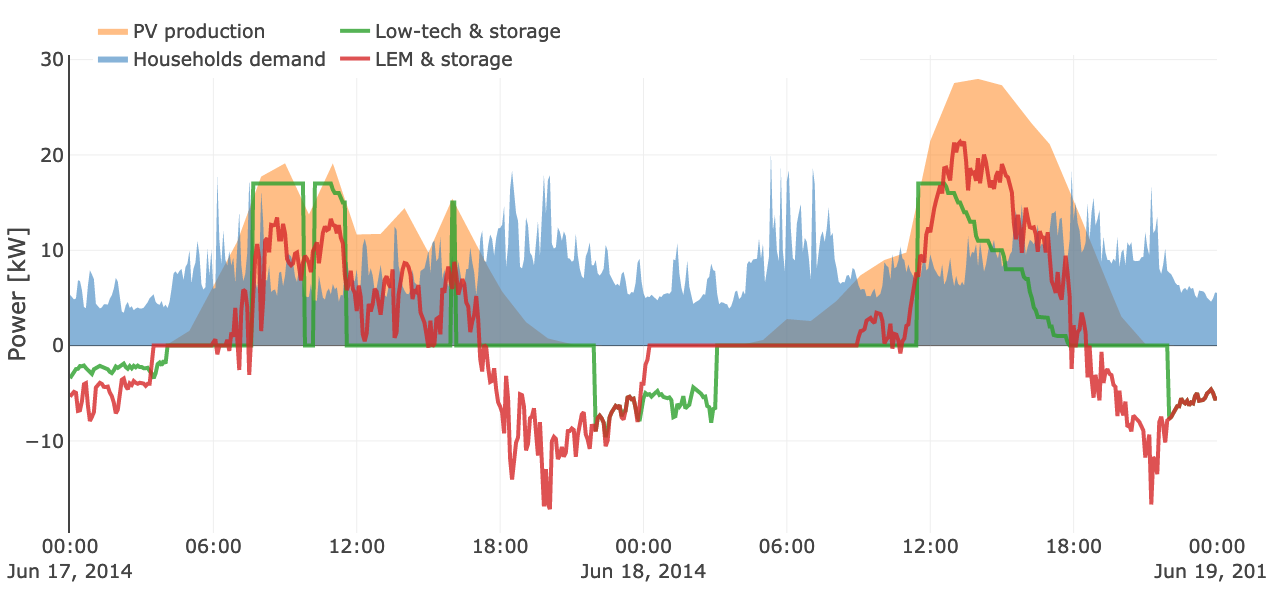

In [14]:
tmp = df.copy()
pv_capacity = 40
tmp['pv_kW'] = tmp['pv_coef'] * pv_capacity
start = '2014-06-17 00:00:00'
end = '2014-06-19 00:00:00'

fig = {
    'data': [
        
        {'x': tmp.loc[start:end, :].index,
         'y': tmp.loc[start:end, 'pv_kW'],
         'mode': 'lines',
         'fill': 'tozeroy',
         'line': {'width' : 0, 'color': 'rgba(255, 127, 14, 0.8)'},
         'fillcolor': 'rgba(255, 127, 14, 0.5)',
         'name': 'PV production',
         'legendgroup': 'area',
#          'stackgroup': 'one'
        },

        {'x': tmp.loc[start:end, :].index,
         'y': tmp.loc[start:end, 'houses_kW'],
         'mode': 'lines',
         'line': {'width' : 0, 'color': 'rgba(55, 128, 191, 1.0)'},
         'fillcolor': 'rgba(55, 128, 191, 0.6)',
         'fill': 'tozeroy',
         'name': 'Households demand',
         'legendgroup': 'area',
#          'stackgroup': 'one'
        },
        
        
        {'x': lowtech[pv_capacity].loc[start:end, :].index,
         'y': lowtech[pv_capacity].loc[start:end, 'battery_kW'],
         'mode': 'lines',
         'line': {'width' : 4, 'color': 'rgba(44, 160, 44, 0.8)'},
         'legendgroup': 'line',
         'name': 'Low-tech & storage'},

        {'x': predictive[pv_capacity].loc[start:end, :].index,
         'y': predictive[pv_capacity].loc[start:end, 'battery_kW'],
         'mode': 'lines',
         'line': {'width' : 4, 'color': 'rgba(214, 39, 40, 0.8)'},
         'legendgroup': 'line',
         'name': 'LEM & storage'},

    ]
,
    'layout': {
        'title': '',
        'xaxis': {'title': '', 'zerolinewidth': 2, 'zeroline': True},
        'yaxis': {'title': 'Power [kW]', 'showline': True, 'linewidth': 2,
#                   'ticksuffix': 'kW'
                 },
        'showlegend': True,
        'legend': {'x': 0.02, 'y': 1.09,
                   'orientation': 'h',
                   'borderwidth': 0},
        'font': {'size': 19},
        'height': 600,
        'width': 900,
        'margin': {'l': 70, 't': 15, 'b': 67, 'r': 51},
    }
}
iplot(fig)

In [15]:
pio.write_image(fig, "graphs/twodays.pdf")

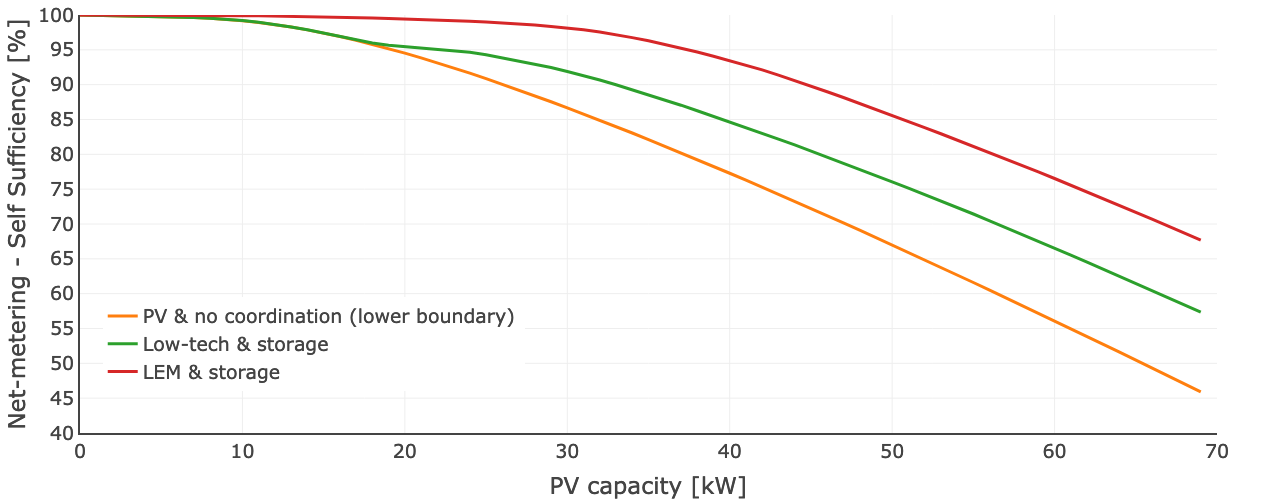

In [16]:
fig = {
    'data': [

#         {'x': pv_capacities,
#          'y': yearly_net_energy,
#          'mode': 'lines',
#          'line': {'width' : 3},
#          'name': 'Yearly net-metering (upper boundary)'},
        
        {'x': pv_capacities,
         'y': [100 - (b - a) for a, b in zip(yearly_self_produced, yearly_net_energy)],
         'mode': 'lines',
         'line': {'width' : 3, 'color': 'rgba(255, 127, 14, 1.0)'},
         'name': 'PV & no coordination (lower boundary)'},

        {'x': pv_capacities,
         'y': [100 - (b - a)for a, b in zip(yearly_self_produced_lowtech, yearly_net_energy)],
         'mode': 'lines',
         'line': {'width' : 3, 'color': 'rgba(44, 160, 44, 1.0)'},
         'name': 'Low-tech & storage'},
        
        {'x': pv_capacities,
         'y': [100 - (b - a) for a, b in zip(yearly_self_produced_predictive, yearly_net_energy)],
         'mode': 'lines',
         'line': {'width' : 3, 'color': 'rgba(214, 39, 40, 1.0)'},
         'name': 'LEM & storage'},
    ]
,
    'layout': {
        'xaxis': {'title': 'PV capacity [kW]',
                 'linewidth': 2, 'showline': True,
                 'range':[0, 70]},
        'yaxis': {'title': 'Net-metering - Self Sufficiency [%]',
                 'linewidth': 2, 'dtick': 5,
                 'range':[40, 100]},
        'showlegend': True,
        'legend': {'x': 0.02, 'y': .1},
        'font': {'size': 19},
        'width': 800,
        'height': 500,
        'margin': {'l': 80, 't': 15, 'b': 67, 'r': 51},
    }
}
iplot(fig)

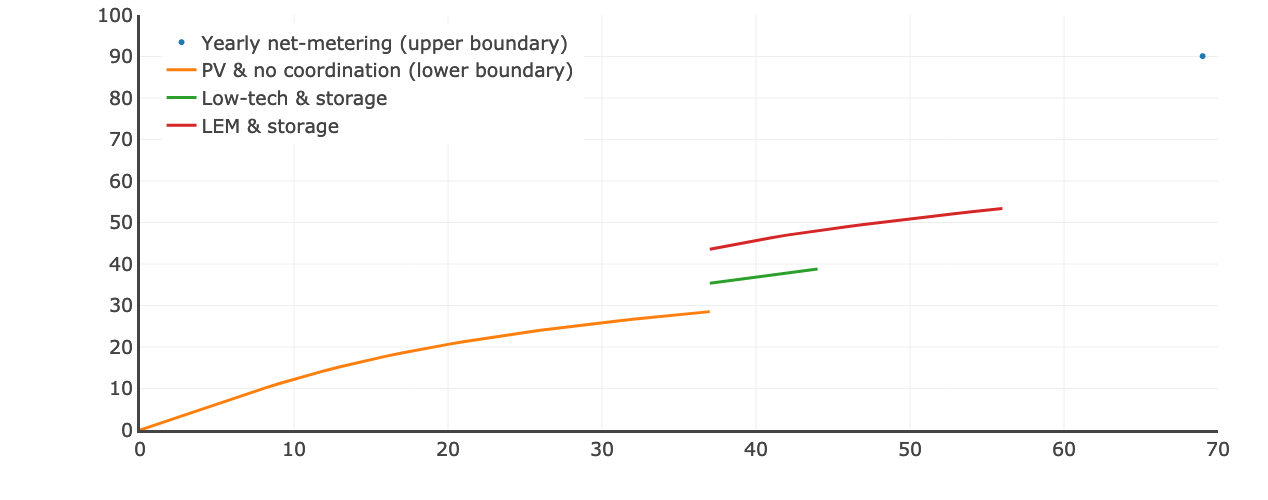

In [17]:
fig = {
    'data': [

        {'x': pv_capacities[-1:],
         'y': yearly_net_energy[-1:],
         'mode': 'markers',
         'name': 'Yearly net-metering (upper boundary)'},
        
        {'x': pv_capacities[:38],
         'y': yearly_self_produced[:38],
         'mode': 'lines',
         'line': {'width' : 3},
         'name': 'PV & no coordination (lower boundary)'},

        {'x': pv_capacities[37:45],
         'y': yearly_self_produced_lowtech[37:45],
         'mode': 'lines',
         'line': {'width' : 3},
         'name': 'Low-tech & storage'},
        
        {'x': pv_capacities[37:57],
         'y': yearly_self_produced_predictive[37:57],
         'mode': 'lines',
         'line': {'width' : 3},
         'name': 'LEM & storage'},
    ]
,
    'layout': {
        'xaxis': {'title': '',
                 'linewidth': 3, 'showline': True,
                 'range':[0, 70]},
        'yaxis': {'title': '',
                 'linewidth': 3, 'dtick': 10,
                 'range':[0, 100]},
        'showlegend': True,
        'legend': {'x': 0.02, 'y': .98},
        'font': {'size': 19},
        'width': 800,
        'height': 500,
        'margin': {'l': 140, 't': 15, 'b': 70, 'r': 50},
    }
}
iplot(fig)